In [1]:
from __future__ import print_function, division

from pitch_perfect.thinkdsp import thinkdsp, thinkplot

import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10   # Time and Hz, i.e. labels
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 15  # Time(x) tick values
plt.rcParams['ytick.labelsize'] = 15  # Hz(y) tick values
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['figure.titlesize'] = 10
plt.rcParams['axes.titlesize'] = 14   # Title font

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%matplotlib inline
PI2 = np.pi * 2

import soundcard as sc
import IPython.display as ipd

from pitch_perfect.data.constants import *

# get a list of all speakers:
speakers = sc.all_speakers()
# get the current default speaker on your system:
default_speaker = sc.default_speaker()
# get a list of all microphones:
mics = sc.all_microphones()
# get the current default microphone on your system:
default_mic = sc.default_microphone()

from pitch_perfect import make_spectrum
from pitch_perfect import PATHS
from pitch_perfect.thinkdsp import asp

## Test autocorrelation on piano

In [2]:
def get_piano_audio():
    waves = {}
    for i in range(8):
        waves[f'c{i}'] = thinkdsp.read_wave(PATHS.data / f'piano/c{i}.wav')
        waves[f'd{i}'] = thinkdsp.read_wave(PATHS.data / f'piano/d{i}.wav')
    return waves

piano_waves = get_piano_audio()
piano_waves['c0'].make_audio()

## Autocorrelatioin

Text(0, 0.5, 'Correlation')

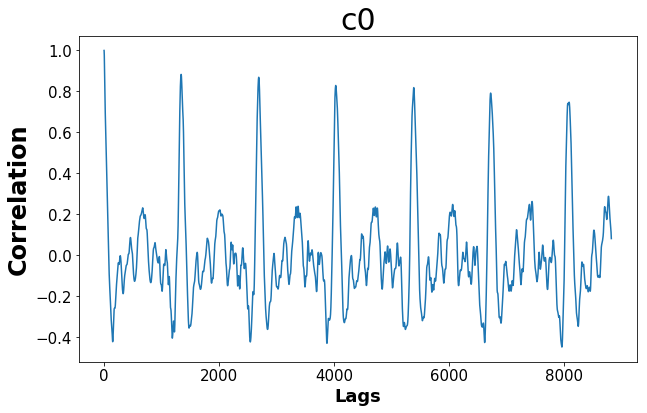

In [3]:
def autocorrelate(ys):
    N = len(ys)
    lengths = range(N, N//2, -1)
    
    corrs = np.correlate(
        ys, 
        ys, 
        mode='same'  # Range of lag. 'same' is in the range from -N/2 to N/2,
                     # where N is the length of the given segment
        )
    
    # The 'same' mode return a symmetric autocorrelation values which is in 
    # the range from -N/2 to N/2. Take only the positive half.
    corrs = corrs[N//2:]
    
    # Offset diminish over time
    corrs /= lengths
    # Normalize so -1 <= corrs <= 1
    corrs /= corrs[0]
    return corrs

plt.figure(figsize=(10, 6))
plt.plot(autocorrelate(piano_waves['c0'].ys[44100:44100+4410*4]))
plt.title('c0', fontsize=30)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=24)

Text(0, 0.5, 'Correlation')

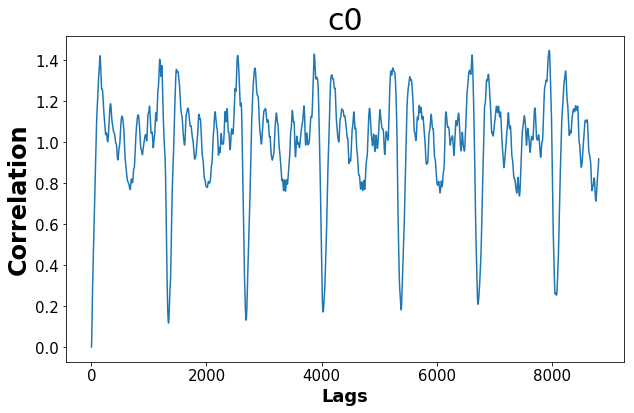

In [4]:
corrs = autocorrelate(piano_waves['c0'].ys[44100:44100+4410*4])
corrs *= -1
corrs += 1
plt.figure(figsize=(10, 6))
plt.plot(corrs)
plt.title('c0', fontsize=30)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=24)

## Step 3. Cumulative mean normalized diff. function

Text(0, 0.5, 'Correlation')

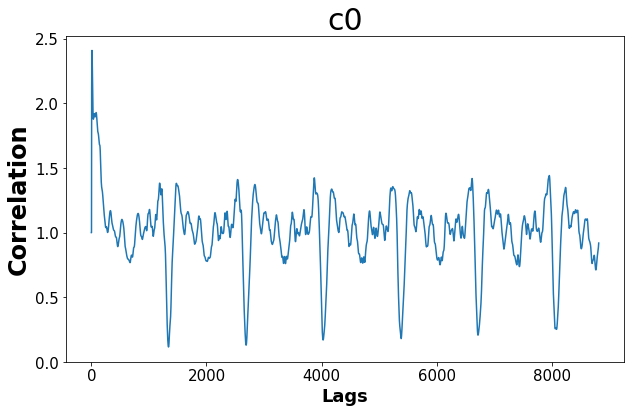

In [6]:
def cumulative_mean_normalized(corrs):
    corrs *= -1
    corrs += 1
    cmn = np.zeros(corrs.shape)
    cmn[0] = 1
    for lag in range(1, len(corrs)) :
        cmn[lag] = corrs[lag] / (
           np.sum(corrs[1:lag+1]) / lag
        )  
    return cmn

corrs = autocorrelate(piano_waves['c0'].ys[44100:44100+4410*4])
cmn = cumulative_mean_normalized(corrs)
plt.figure(figsize=(10, 6))
plt.plot(cmn)
plt.title('c0', fontsize=30)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=24)

## YIN vs. Autocorrelation Benchmark 

In [6]:
for pitch_gt in piano_waves.keys():
    pitch, freq = asp.YIN.get_pitch_freq(piano_waves[pitch_gt].ys[44100:44100+4410*4])
    print(f'GT: {pitch_gt}, Prediction: {pitch}', pitch_gt == pitch)

GT: c0, Prediction: c0 True
GT: d0, Prediction: d0 True
GT: c1, Prediction: c1 True
GT: d1, Prediction: d1 True
GT: c2, Prediction: c2 True
GT: d2, Prediction: d2 True
GT: c3, Prediction: c3 True
GT: d3, Prediction: d3 True
GT: c4, Prediction: c4 True
GT: d4, Prediction: d4 True
GT: c5, Prediction: c5 True
GT: d5, Prediction: d5 True
GT: c6, Prediction: c6 True
GT: d6, Prediction: d6 True
GT: c7, Prediction: a8 False
GT: d7, Prediction: a8 False


In [7]:
for pitch_gt in piano_waves.keys():
    pitch, freq = asp.Autocorrelation.get_pitch_freq(autocorrelate(piano_waves[pitch_gt].ys[44100:44100+4410*4]))
    print(f'GT: {pitch_gt}, Prediction: {pitch}', pitch_gt == pitch)

GT: c0, Prediction: c0 True
GT: d0, Prediction: d0 True
GT: c1, Prediction: c1 True
GT: d1, Prediction: d1 True
GT: c2, Prediction: c3 False
GT: d2, Prediction: d2 True
GT: c3, Prediction: c3 True
GT: d3, Prediction: d3 True
GT: c4, Prediction: c4 True
GT: d4, Prediction: d4 True
GT: c5, Prediction: c5 True
GT: d5, Prediction: d5 True
GT: c6, Prediction: c6 True
GT: d6, Prediction: d6 True
GT: c7, Prediction: a8 False
GT: d7, Prediction: a8 False


## Plots

In [6]:

pitch_, freq_, corrs_, cmn_, ys_ = asp.Autocorrelation.get_pitch_freq(autocorrelate(piano_waves['c2'].ys[44100:44100+4410*4]))
period_ = int(44100 / freq_)

corrs = autocorrelate(piano_waves['c2'].ys[44100:44100+4410*4])
cmn = cumulative_mean_normalized(corrs)
cmn[period_]

0.30001652546866425

In [16]:

ys_ = Autocorrelation.get_pitch_freq(autocorrelate(piano_waves['c2'].ys[44100:44100+4410*4]))

NameError: name 'freq2key' is not defined

In [13]:
ys_.shape, piano_waves['c2'].ys[44100:44100+4410*4].shape

((8820,), (17640,))

In [8]:
ys_.shape[0] / piano_waves['c2'].ys[44100:44100+4410*4].shape[0]

0.5

In [12]:
cmn.shape

(8820,)

In [13]:
cmn_.shape

(4410,)

In [14]:
corrs.shape, corrs_.shape

((8820,), (4410,))

In [10]:
np.alltrue(cmn_, cmn)

TypeError: only integer scalar arrays can be converted to a scalar index

In [7]:
def absolute_threshold(cmn, samplerate=44100, threshold=0.1):
    """
    Args:
        cmn (np.array): Cumulative mean normalized difference

    Return fundamental frequency of chunk
    """
    def cannot_apply_absolute_threshold(cmn):
        return np.alltrue(cmn > threshold)

    if cannot_apply_absolute_threshold(cmn):
        # Return global minimum period
        return  44100 / np.argmin(cmn)

    first_dip_start = np.argmax(cmn < threshold)
    first_dip_end = np.argmax(cmn[first_dip_start:] > threshold) + first_dip_start

    absolute_threshold_min = np.argmin(
        cmn[first_dip_start:first_dip_end]
    ) + first_dip_start

    return 44100 / absolute_threshold_min

print(absolute_threshold(cmn), freq)

131.25 260.94674556213016


In [8]:
cmn[period], cmn[int(44100/absolute_threshold(cmn))]

(0.30001652546866425, 0.018313369179592125)

In [14]:
period

169

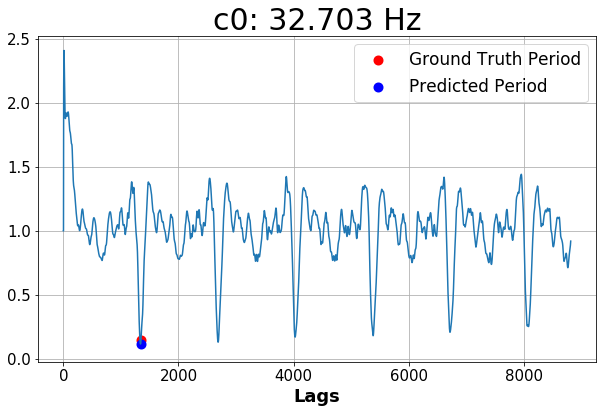

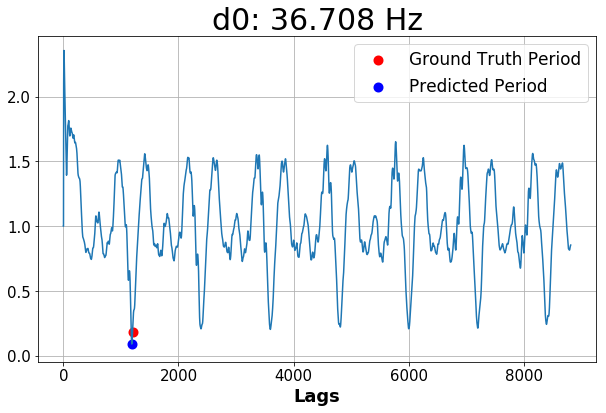

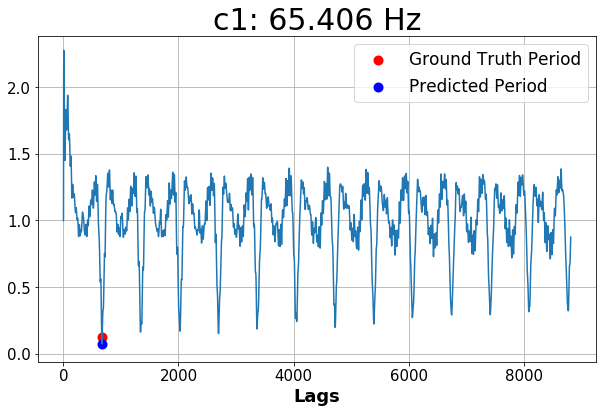

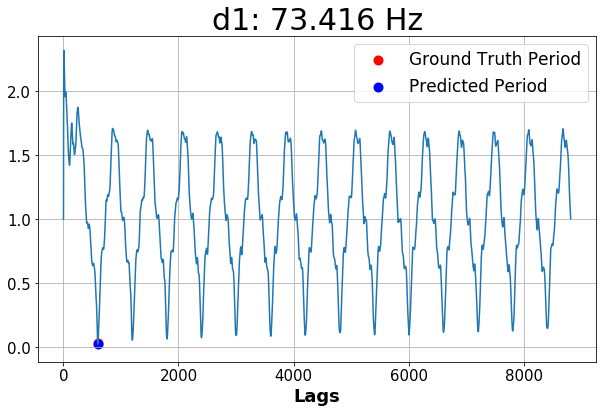

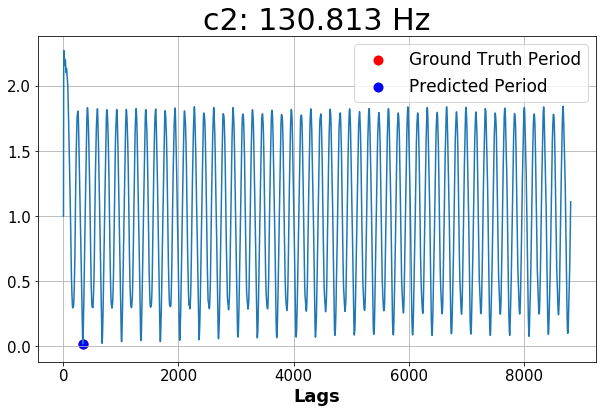

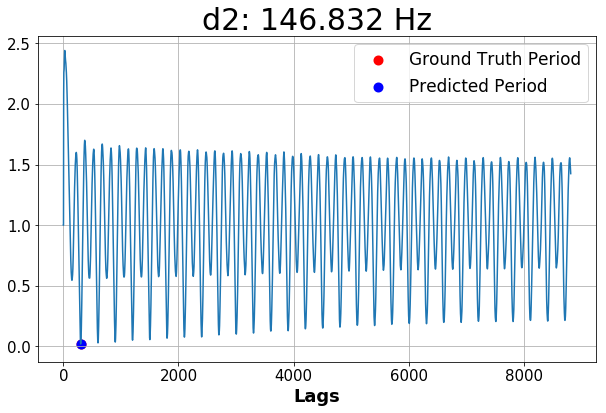

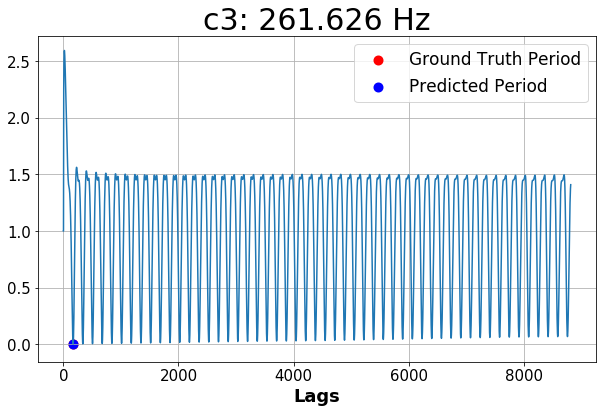

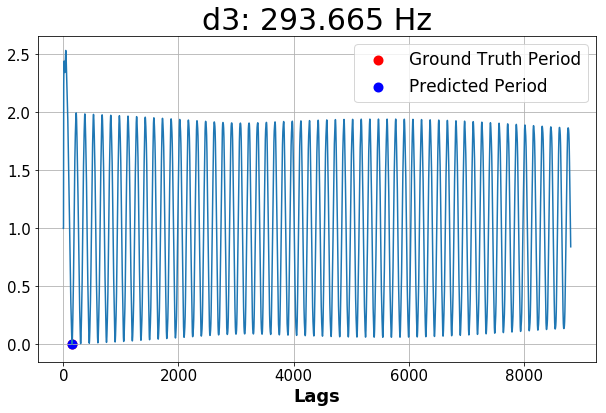

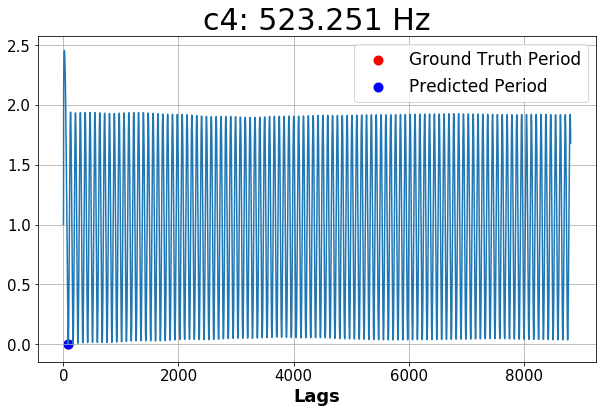

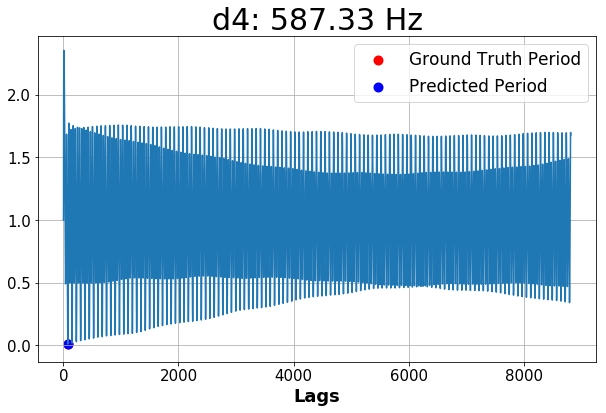

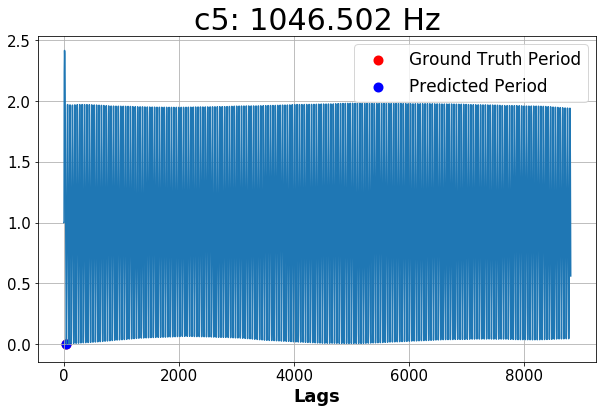

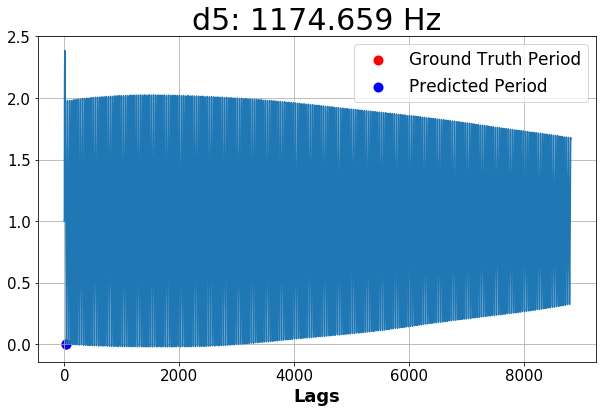

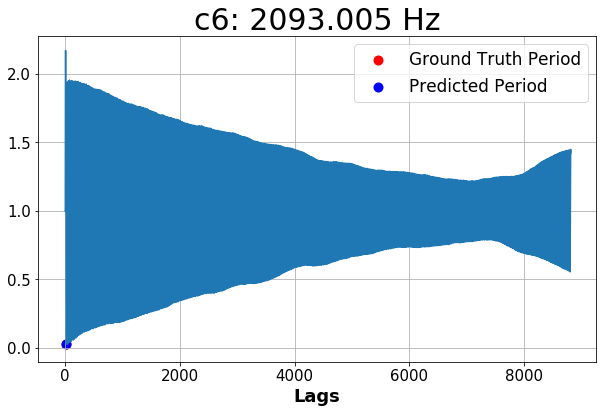

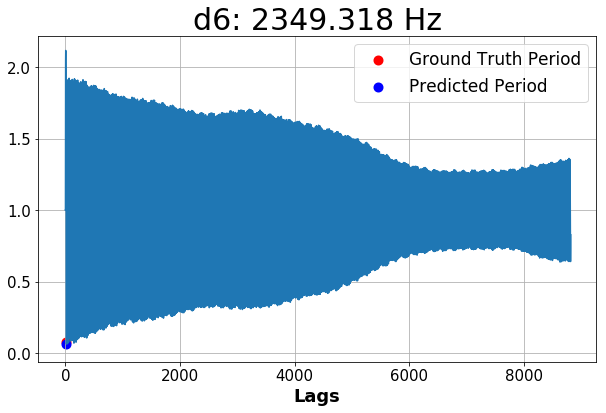

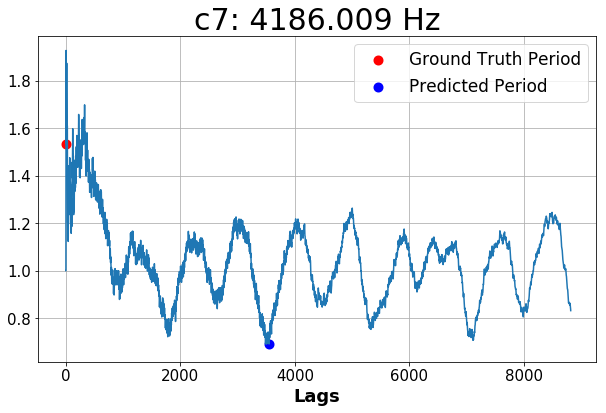

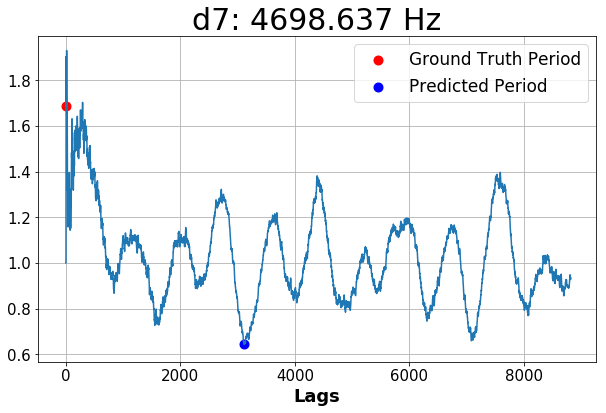

In [9]:
for pitch_gt in piano_waves.keys():
    pitch, freq = asp.Autocorrelation.get_pitch_freq(piano_waves[pitch_gt].ys[44100:44100+4410*4])
    period = int(44100 / freq)
    title = f'GT: {pitch_gt}, Prediction: {pitch}', pitch_gt == pitch
    
    corrs = autocorrelate(piano_waves[pitch_gt].ys[44100:44100+4410*4])
    cmn = cumulative_mean_normalized(corrs)
    
    plt.figure(figsize=(10, 6))
    plt.plot(cmn)
    freq_gt = KEY_FREQUENCY_MAP[pitch_gt]
    period_gt = int(44100/freq_gt)
    
    plt.scatter([period_gt], [cmn[period_gt]], c='r', lw=4, label='Ground Truth Period')
    plt.scatter([period], [cmn[period]], c='b', lw=4, label='Predicted Period')
    
    plt.title(f'{pitch_gt}: {freq_gt} Hz', fontsize=30)
    plt.xlabel('Lags', fontsize=18)
    plt.legend(loc=1)
    plt.grid(True)

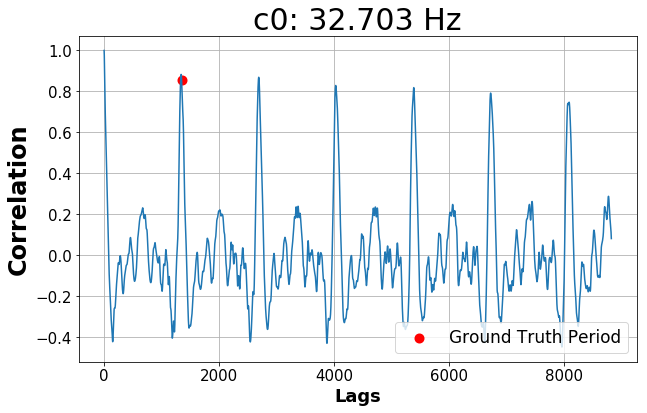

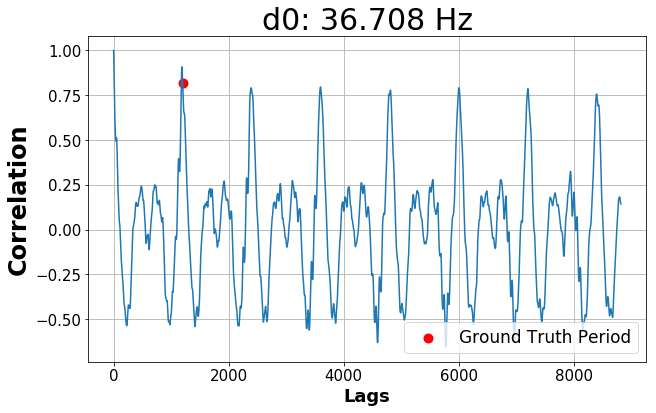

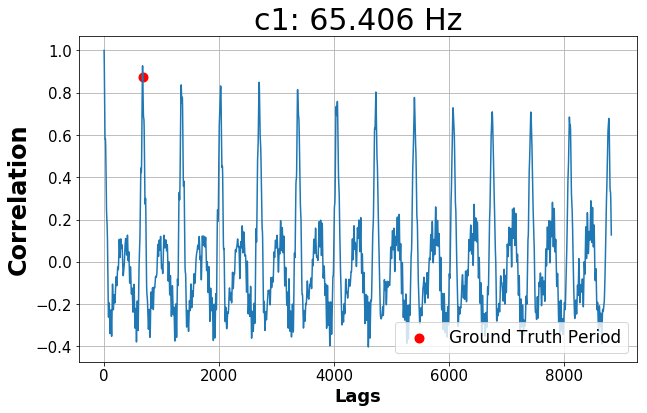

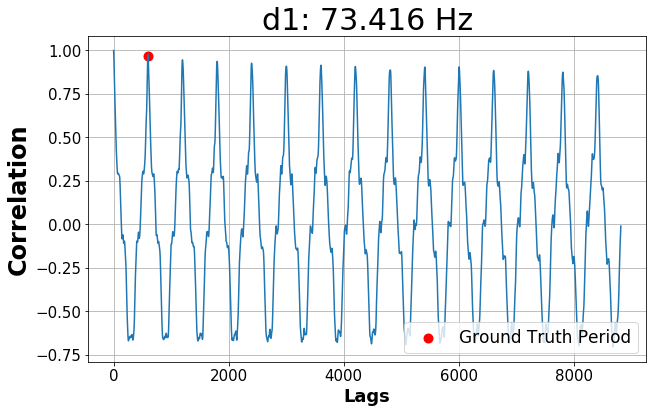

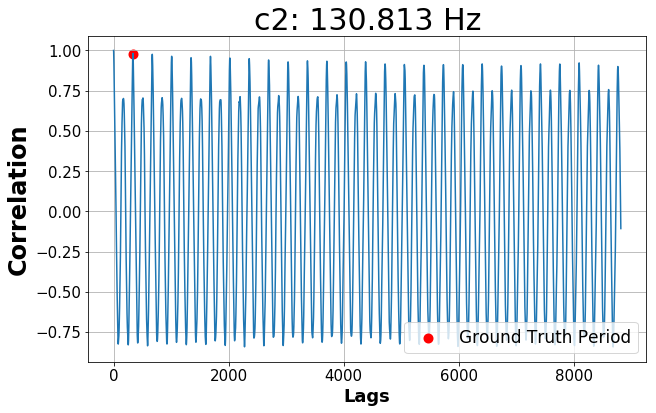

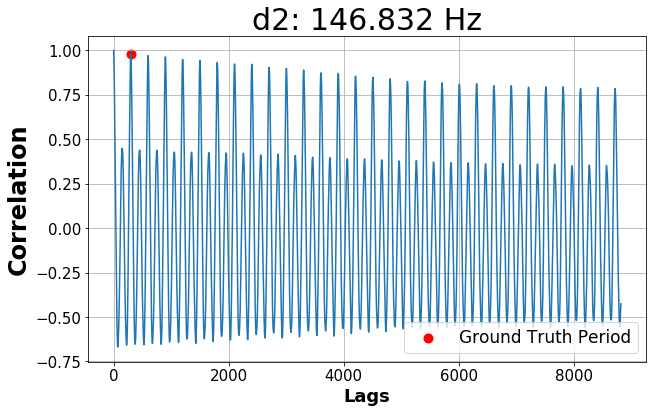

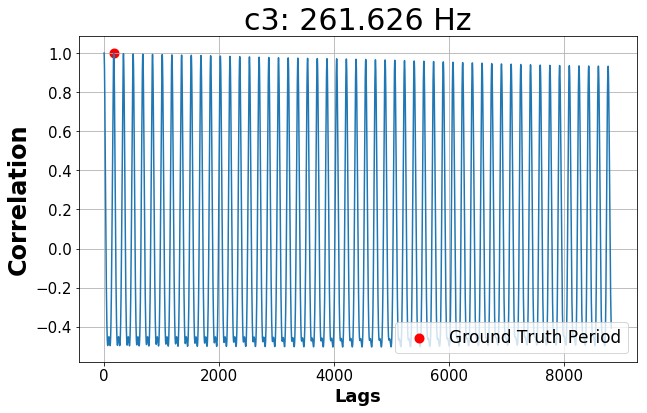

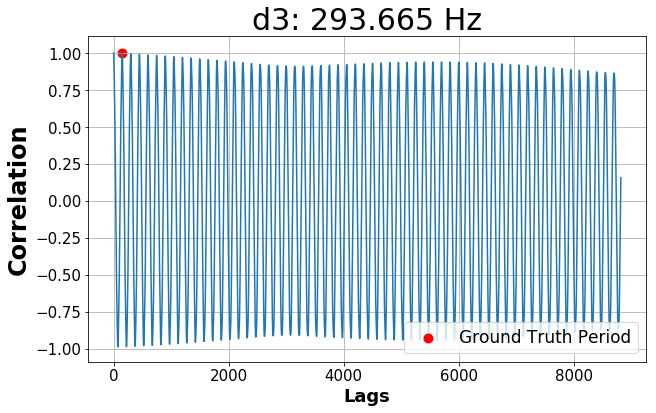

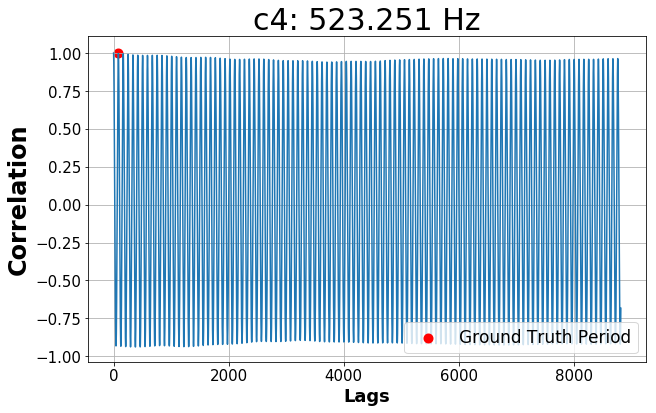

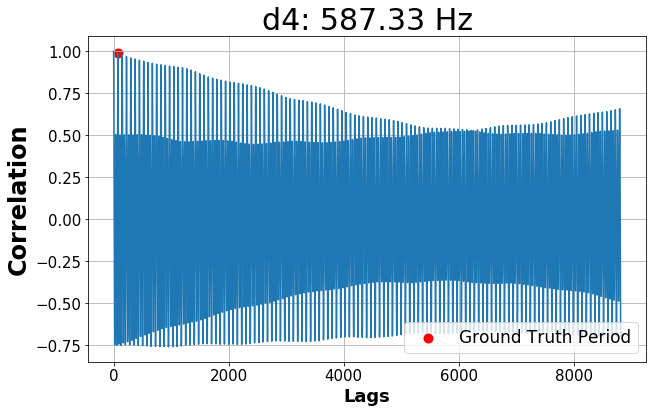

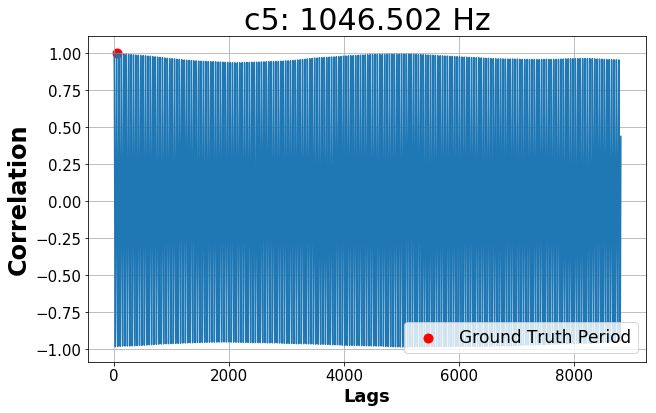

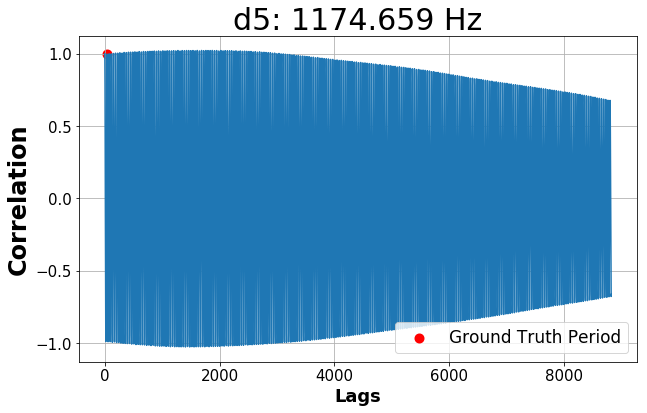

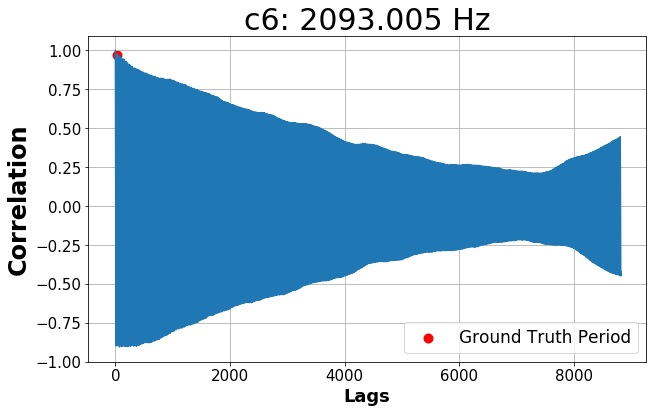

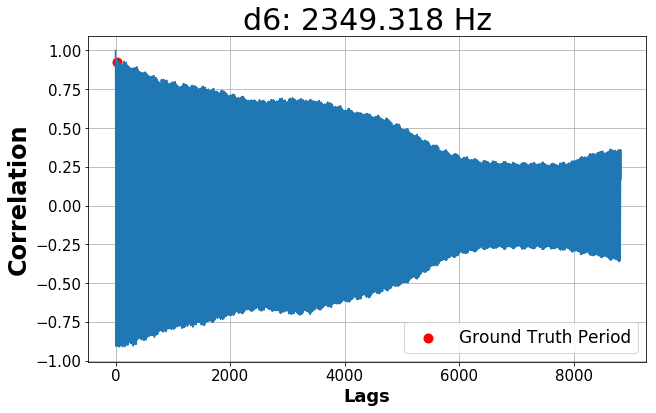

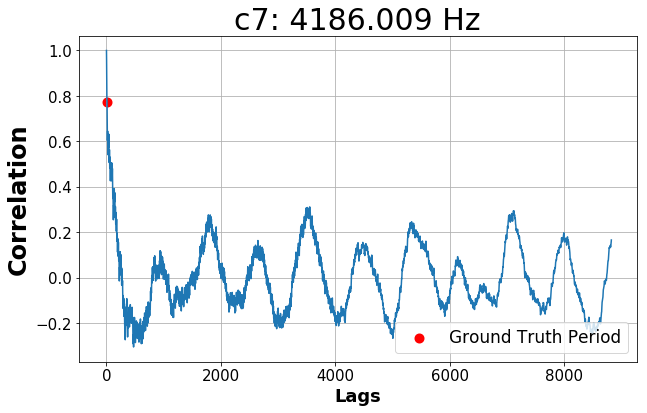

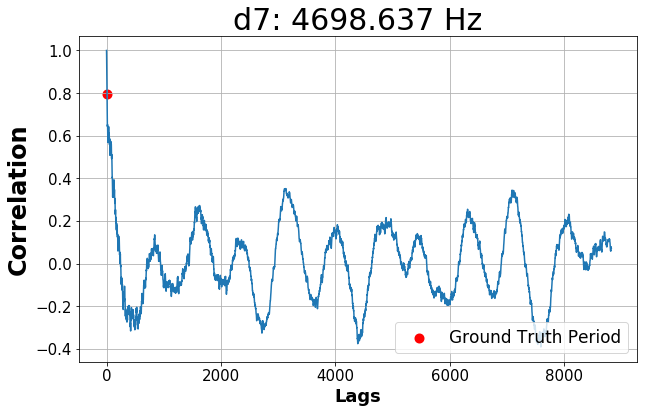

In [6]:
for pitch_gt in piano_waves.keys():
    corrs = autocorrelate(piano_waves[pitch_gt].ys[44100:44100+4410*4])
    plt.figure(figsize=(10, 6))
    plt.plot(corrs)
    freq_gt = KEY_FREQUENCY_MAP[pitch_gt]
    period_gt = int(44100/freq_gt)
    plt.scatter([period_gt], [corrs[period_gt]], c='r', lw=4, label='Ground Truth Period')
    plt.title(f'{pitch_gt}: {freq_gt} Hz', fontsize=30)
    plt.xlabel('Lags', fontsize=18)
    plt.ylabel(r"Correlation", fontsize=24)
    plt.legend(loc=4)
    plt.grid(True)